# Bayesian Hypothesis Testing

An alternative to frequentist hypothesis testing. The method uses Monte Carlo simulations.

In [1]:
import itertools
from collections import Counter

try:
    import numpy as np
except ImportError:
    !{sys.executable} -m pip install numpy==1.17.4
try:
    import seaborn as sns
except ImportError:
    !{sys.executable} -m pip install seaborn==0.9.0

import numpy as np
import seaborn as sns

In [2]:
np.random.seed(10)

# Set the figure size for seaborn
sns.set(rc={'figure.figsize':(11.7, 8.27)})

### Data Sample
Suppose we have transactional data (per segment) from a retail store, that looks like:

| Segment A | Segment B | Segment C | Segment D |
|---|---|---|---|
| 1 | 3 | 1 | 2 |
| 0 | 1 | 2 | 0 |
| ... | ... | ... | ... |
| 2 | 0 | 3 | 8 |

Each value is an amount spent by a customer for that segment


In [3]:
# Data generation

customers_per_segment = 100000
unique_purchase_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
variations_distributions = {
    'A': [0.6, 0.2, 0.1, 0.05, 0.05, 0, 0, 0, 0, 0],
    'B': [0.65, 0.2, 0.1, 0.03, 0.02, 0, 0, 0, 0, 0],
    'C': [0.67, 0.2, 0.1, 0.02, 0.01, 0, 0, 0, 0, 0],
    'D': [0.68, 0.05, 0.05, 0.05, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01],
}

purchases = {
    segment: np.random.choice(unique_purchase_values, (customers_per_segment,), p=pvals) 
    for segment, pvals in variations_distributions.items()
}

## Binary variable
Has the customer in a particular segment made a purchase (amount > 0) or not?

In [4]:
# Setting uniform priors (no bias) for test and control segments
alpha_prior, beta_prior = 1, 1
# Number of samples to draw from the beta distribution
beta_simulation_size = 100000

simulation_data_binary = {}
for variation, variation_data in purchases.items():
    # Number of "conversions" - customers who made a purchase
    alpha = len(variation_data[variation_data > 0])
    # Number of "failures" - customers who did not make a purchase (amount = 0)
    beta = len(variation_data) - alpha
    
    # Given alpha and beta, draw random samples from a beta distribution, "beta_simulation_size" times
    simulation = np.random.beta(alpha + alpha_prior, beta + beta_prior, size=beta_simulation_size)
    simulation_data_binary[variation] = simulation

hypothesis_results_binary = {}
for segment_control, segment_test in itertools.product(purchases.keys(), purchases.keys()):
    if segment_test == segment_control:
        continue
    
    simulation_control = simulation_data_binary[segment_control]
    simulation_test = simulation_data_binary[segment_test]

    # How many times, out of the simulated probabilities, the control segment beats the test segment
    control_beats_test = simulation_control > simulation_test
    control_beats_test_probability = (sum(control_beats_test) / beta_simulation_size) * 100
    hypothesis_results_binary[f'{segment_control}_beats_{segment_test}'] = round(control_beats_test_probability, 2)
        
print(hypothesis_results_binary)

{'A_beats_B': 100.0, 'A_beats_C': 100.0, 'A_beats_D': 100.0, 'B_beats_A': 0.0, 'B_beats_C': 100.0, 'B_beats_D': 100.0, 'C_beats_A': 0.0, 'C_beats_B': 0.0, 'C_beats_D': 100.0, 'D_beats_A': 0.0, 'D_beats_B': 0.0, 'D_beats_C': 0.0}


Text(0.5, 1.0, 'A vs B')

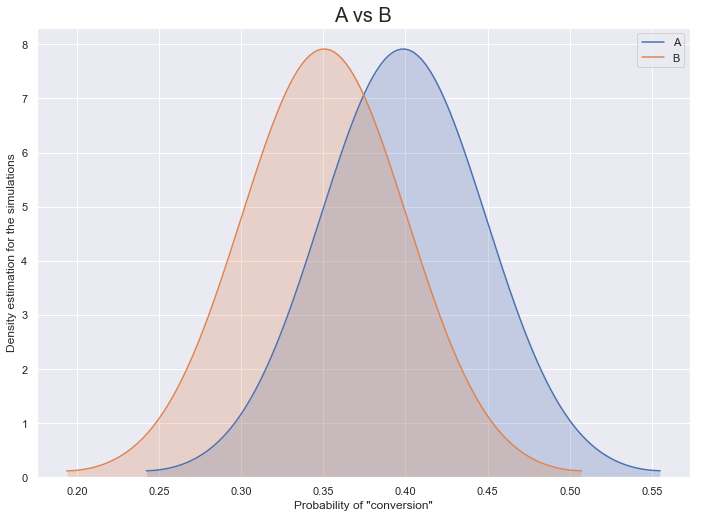

In [5]:
ax = sns.kdeplot(simulation_data_binary['A'], bw=0.05, shade=True, legend=True, label='A')
sns.kdeplot(simulation_data_binary['B'], bw=0.05, shade=True, legend=True, label='B')
ax.set(xlabel='Probability of "conversion"', ylabel='Density estimation for the simulations')
ax.set_title("A vs B", fontsize=20)

## Continuous variable
The amount of money, a customer in a particular segment, has spent

In [6]:
# Continuous variable

# Number of bootstrap samples to draw from the purchase amounts data
bootstrap_simulation_size = 5000
# Number of bootstrap samples to draw for the medians -
# Calculated over the bootstrapped purchase amounts
medians_simulation_size = 50000

simulation_data_continuous = {}
for variation, variation_data in purchases.items():
    non_zero_values = variation_data[variation_data > 0]
    sample_size = len(non_zero_values)
    
    values_counts = sorted(Counter(non_zero_values).items(), key=lambda x: x[0])
    values_aggregated = np.array([x[0] for x in values_counts])
    weights_aggregated = np.array([x[1] for x in values_counts])
    
    pvals_aggregated = weights_aggregated / sum(weights_aggregated)
    draws = np.random.choice(values_aggregated, 
                             size=(bootstrap_simulation_size, sample_size), 
                             replace=True, p=pvals_aggregated)
    
    medians = np.median(draws, axis=1, overwrite_input=True)
    simulation_data_continuous[variation] = np.random.choice(medians, medians_simulation_size, replace=True)

hypothesis_results_continuous = {}
for segment_control, segment_test in itertools.product(purchases.keys(), purchases.keys()):
    if segment_test == segment_control:
        continue

    number_of_times_better = sum(
        simulation_data_continuous[segment_control] > 
        simulation_data_continuous[segment_test]
    )
    control_beats_test_probability = number_of_times_better / medians_simulation_size
    control_beats_test_probability = round(control_beats_test_probability * 100, 2)
    hypothesis_results_continuous[f'{segment_control}_beats_{segment_test}'] = control_beats_test_probability

print(hypothesis_results_continuous)

{'A_beats_B': 14.42, 'A_beats_C': 14.42, 'A_beats_D': 0.0, 'B_beats_A': 0.0, 'B_beats_C': 0.0, 'B_beats_D': 0.0, 'C_beats_A': 0.0, 'C_beats_B': 0.0, 'C_beats_D': 0.0, 'D_beats_A': 100.0, 'D_beats_B': 100.0, 'D_beats_C': 100.0}


Text(0.5, 1.0, 'A vs B vs D')

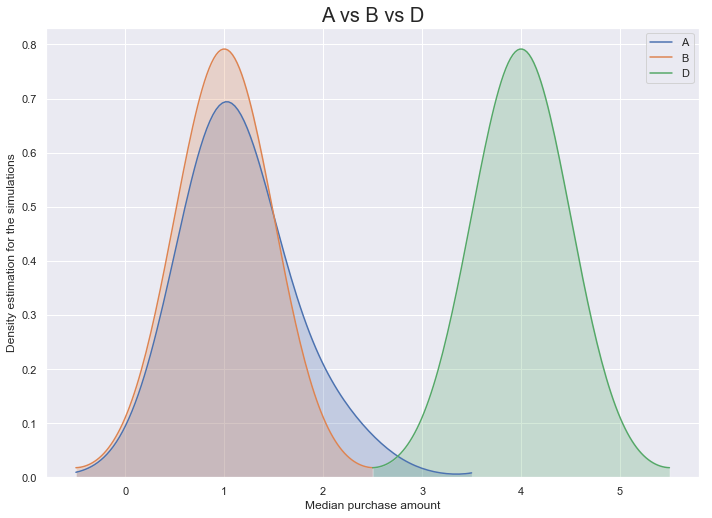

In [7]:
ax = sns.kdeplot(simulation_data_continuous['A'], bw=0.5, shade=True, legend=True, label='A')
sns.kdeplot(simulation_data_continuous['B'], bw=0.5, shade=True, legend=True, label='B')
sns.kdeplot(simulation_data_continuous['D'], bw=0.5, shade=True, legend=True, label='D')
ax.set(xlabel='Median purchase amount', ylabel='Density estimation for the simulations')
ax.set_title("A vs B vs D", fontsize=20)